# <a id='toc1_'></a>[**Transfer Learning with TensorFlow Part 2 : Fine-Tuning**](#toc0_)

Reference: https://github.com/mrdbourke/tensorflow-deep-learning

In the previous notebook, we covered transfer learning feature extrction, now it's time to learn about a new kind of transfer learning: fine-tuning

**Table of contents**<a id='toc0_'></a>    
- [**Transfer Learning with TensorFlow Part 2 : Fine-Tuning**](#toc1_)    
  - [**Check your device and version**](#toc1_1_)    
  - [**Creating helper functions**](#toc1_2_)    
  - [**Let's get some data**](#toc1_3_)    
  - [**Model 0: Building a transfer learning feature extraction model using the Keras Functional API**](#toc1_4_)    
  - [**Getting a feature vector from a trained model**](#toc1_5_)    
  - [**Running a series of transfer learning experiments**](#toc1_6_)    
    - [**Getting and preprocessing data for model_1**](#toc1_6_1_)    
    - [**Adding data augmentation right into the model**](#toc1_6_2_)    
    - [Visualize our data augmentation layer (and see what happens to our data)](#toc1_6_3_)    
  - [**Model 1 : Feature extraction trasfer learning on 1% of the data with data augmentation**](#toc1_7_)    
  - [**Model 2 : Feature extraction trasfer learning on 10% of the data with data augmentation**](#toc1_8_)    
    - [**Creating a ModelCheckpoint callback**](#toc1_8_1_)    
    - [**Fit model 2 passing the the ModelCheckpoint callback**](#toc1_8_2_)    
    - [Losding in checkpointed weights](#toc1_8_3_)    
  - [**Model 3 : Fine-tuning an existing model on % of the data**](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a id="1"></a>
## <a id='toc1_1_'></a>[**Check your device and version**](#toc0_)

In [1]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-05-27 22:24:02.328464


In [2]:
# Are we using a GPU?
!nvidia-smi

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat May 27 22:24:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   33C    P8     8W / 300W |    279MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

```
Tue May 23 09:26:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   31C    P8     8W / 300W |  47810MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1315      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A      9270      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     15698      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     51864    C+G   ...ome-remote-desktop-daemon      261MiB |
|    0   N/A  N/A     81175      C   ...11__python_3.9/bin/python    47531MiB |
+-----------------------------------------------------------------------------+
```

In [3]:
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

import tensorflow as tf
print("TensorFlow version is",tf.__version__)

print("Are we using a GPU?",len(tf.config.experimental.list_physical_devices('GPU'))>0)

posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.19.0-42-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True


* posix = Linux, nt = windows, java = java
* your os name is posix
* your os is  Linux5.19.0-42-generic
* python version is 3.9.16
* TensorFlow version is 2.8.3
* Are we using a GPU? True

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
## <a id='toc1_2_'></a>[**Creating helper functions**](#toc0_)

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# for linux command
if os.path.exists("helper_functions.py") != True:
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# for windows command
# import wget
# if os.path.exists("helper_functions.py") != True:
#     wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

In [5]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, download_file


> 🔑**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## <a id='toc1_3_'></a>[**Let's get some data**](#toc0_)

This time we're going to see how we can use the pretrained models whithin `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# Get 10% of training data of 10 classes of Food101

# for linux command
if os.path.exists("10_food_classes_10_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # for windows
# import wget

# if os.path.exists("10_food_classes_10_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip')
#     print("Download Scucess")


unzip_data("10_food_classes_10_percent.zip")

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-27 22:24:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:2::2010, 2404:6800:4012:3::2010, 2404:6800:4012:4::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:2::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 168546183 (161M) [application/zip]
儲存到：‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.4MB/s    於 5.3s     

2023-05-27 22:24:09 (30.1 MB/s) - 已儲存 ‘10_food_classes_10_percent.zip’ [168546183/168546183]



In [7]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_10_percent.zip/ # linux
# !rd /s /q 10_food_classes_10_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_10_percent.zip"

# for linux
!rm -rf 10_food_classes_10_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [8]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [9]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [10]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
# Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    tf.print(images,labels)

[[[[219.571426 226.571426 232.571426]
   [225.831635 233.831635 236.831635]
   [227 235 238]
   ...
   [100.647995 110.4235 107.571404]
   [101.974487 112.974487 106.974487]
   [99.2856827 110.999962 102.642822]]

  [[218.928574 225.928574 231.928574]
   [226.785721 234.785721 237.785721]
   [228.341827 236.341827 239.341827]
   ...
   [99.9438553 112.158142 108.484627]
   [96.7193756 111.862236 104.790802]
   [95.3826218 111.668335 101.739761]]

  [[217.357147 224.357147 230.357147]
   [225.943893 233.943893 236.943893]
   [229.382645 237.382645 240.382645]
   ...
   [94.0713882 110.306114 103.117325]
   [90.8571472 109.428574 103]
   [91.4949265 110.709213 104.066353]]

  ...

  [[53.6581917 65.6581879 65.6581879]
   [51.403038 62.9744492 61.1887436]
   [53.6173172 65.2346573 60.8060837]
   ...
   [53.8111725 49.1633034 45.4234505]
   [50.8572083 49.1429749 41.714386]
   [57.2705 55.5562668 46.1276779]]

  [[58.2602425 68.4030685 70.2602463]
   [48.3520241 58.3520241 59.2092]
   [48.

## <a id='toc1_4_'></a>[**Model 0: Building a transfer learning feature extraction model using the Keras Functional API**](#toc0_)

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [14]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-222417
Epoch 1/5


2023-05-27 22:24:19.925976: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-27 22:24:19.926414: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 5s 89ms/step - loss: 1.9111 - accuracy: 0.3973 - val_loss: 1.3320 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 2s 63ms/step - loss: 1.1456 - accuracy: 0.7547 - val_loss: 0.9184 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 1s 61ms/step - loss: 0.8467 - accuracy: 0.7987 - val_loss: 0.7392 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 2s 62ms/step - loss: 0.6922 - accuracy: 0.8373 - val_loss: 0.6649 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 1s 54ms/step - loss: 0.5925 - accuracy: 0.8680 - val_loss: 0.6148 - val_accuracy: 0.8421


In [15]:
model_0.evaluate(test_data)

79/79 [==============================] - 3s 35ms/step - loss: 0.6109 - accuracy: 0.8364


[0.6109402775764465, 0.8363999724388123]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [17]:
# How about we get a summary of the base model?

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [18]:
# How about we get a summary of our whole model?

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


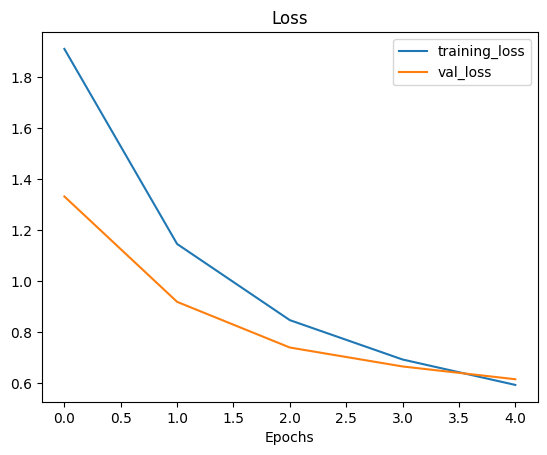

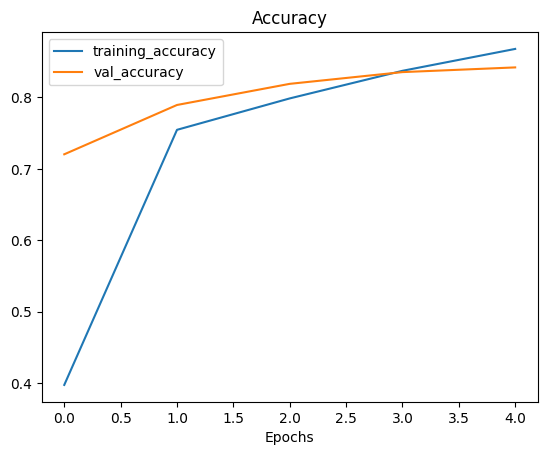

In [19]:
# Check out our model's training cureve

plot_loss_curves(history_10_percent)

## <a id='toc1_5_'></a>[**Getting a feature vector from a trained model**](#toc0_)

Let's demonstrate the Golbal Average Pooling 2D Layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it truns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [20]:
# Define the input shape
input_shape = (1,2,2,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")


# Check the shape of the different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of input tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]]

  [[-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]]]

2D global average pooled random tensor:
[[-0.3371175  -1.0493976   0.17876767]]

Shape of input tensor:(1, 2, 2, 3)
Shape of input tensor:(1, 3)


In [21]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.3371175 , -1.0493976 ,  0.17876767]], dtype=float32)>

經過了2D global average pooled 其實就是feature extraction，AI會知道每個數值代表的意思

>🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

In [22]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. max pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalMaxPool2D(name = "global_max_pooling_layer")(x)
print(f"Shape after GlobalMaxPool2D:{x.shape}")


x = tf.keras.layers.Dense(2048,activation = "relu", name = "fully_connection_1")(x)


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalMaxPool2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-222433
Epoch 1/5
24/24 [==============================] - 4s 80ms/step - loss: 14.0723 - accuracy: 0.2773 - val_loss: 2.6328 - val_accuracy: 0.5066
Epoch 2/5
24/24 [==============================] - 1s 52ms/step - loss: 1.3128 - accuracy: 0.6773 - val_loss: 0.8465 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 1s 56ms/step - loss: 0.4999 - accuracy: 0.8280 - val_loss: 0.6023 - val_accuracy: 0.7911
Epoch 4/5
24/24 [==============================] - 1s 52ms/step - loss: 0.3323 - accuracy: 0.9000 - val_loss: 0.7116 - val_accuracy: 0.7714
Epoch 5/5
24/24 [==============================] - 1s 60ms/step - loss: 0.2442 - accuracy: 0.9240 - val_loss: 0.7147 - val_accuracy: 0.8010


## <a id='toc1_6_'></a>[**Running a series of transfer learning experiments**](#toc0_)

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the raining data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction trasfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tunning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across

### <a id='toc1_6_1_'></a>[**Getting and preprocessing data for model_1**](#toc0_)

In [23]:
# Download and unzip data

# for linux command
if os.path.exists("10_food_classes_1_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# for windows command
# if os.path.exists("10_food_classes_1_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip')

unzip_data("10_food_classes_1_percent.zip")

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-27 22:24:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:4::2010, 2404:6800:4012:2::2010, 2404:6800:4012:3::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:4::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 133612354 (127M) [application/zip]
儲存到：‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  27.6MB/s    於 4.6s     

2023-05-27 22:24:47 (27.6 MB/s) - 已儲存 ‘10_food_classes_1_percent.zip’ [133612354/133612354]



In [24]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_1_percent.zip/ # linux
# !rd /s /q 10_food_classes_1_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_1_percent.zip"

# for linux
!rm -rf 10_food_classes_1_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [25]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [26]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [27]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_1_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### <a id='toc1_6_2_'></a>[**Adding data augmentation right into the model**](#toc0_)

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers()` - https://www.tensorflow.org/api_docs/python/tf/keras/layers

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

Off the top our of head, after reading the docs, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.
* If you use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), you will use CPU to generate your data.

In [28]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc...
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2), 
    #tf.keras.layers.Rescaling(scale=1./255), # keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
],name = "data_augmentation")

### <a id='toc1_6_3_'></a>[Visualize our data augmentation layer (and see what happens to our data)](#toc0_)



In [29]:
# check the class names
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

10_food_classes_1_percent/train/chicken_wings
[[[237 226 196]
  [240 229 199]
  [247 233 207]
  ...
  [108  58  31]
  [112  64  41]
  [112  64  41]]

 [[238 227 199]
  [242 231 203]
  [248 234 208]
  ...
  [110  60  35]
  [113  65  42]
  [113  65  42]]

 [[241 229 203]
  [247 235 209]
  [252 237 214]
  ...
  [112  61  40]
  [114  66  44]
  [112  64  42]]

 ...

 [[240 227 211]
  [240 227 211]
  [240 226 213]
  ...
  [250 252 249]
  [250 252 249]
  [250 252 249]]

 [[240 227 210]
  [240 227 210]
  [239 226 210]
  ...
  [249 251 248]
  [249 251 248]
  [250 252 249]]

 [[239 226 209]
  [239 226 209]
  [239 226 210]
  ...
  [249 251 248]
  [249 251 248]
  [250 252 249]]]
tf.Tensor(
[[[134.20099    77.713295    1.3981196]
  [133.14265    76.97218     2.8166292]
  [139.30275    83.983185   11.60805  ]
  ...
  [244.4317    246.44788   237.28497  ]
  [244.83836   246.44267   236.40878  ]
  [245.64412   245.73137   235.68039  ]]

 [[135.20712    77.861244    1.7783362]
  [133.2257     76.17369 

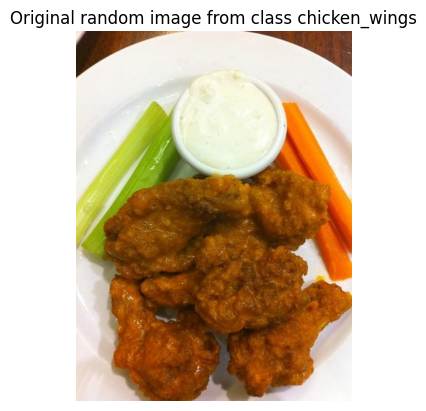

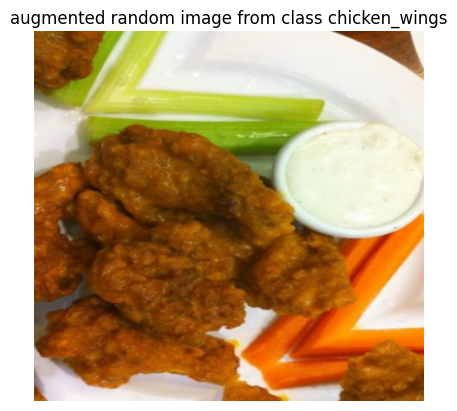

In [30]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
randim_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(randim_image_path)
print(img)
plt.axis(False)
plt.title(f"Original random image from class {target_class}")
plt.imshow(img)

# Now let's plot our augmented random image
augmented_image = data_augmentation(img, training = True)
print(augmented_image)
plt.figure()
plt.axis(False)
plt.title(f"augmented random image from class {target_class}")
plt.imshow(augmented_image.numpy().astype(int))


(235, 186, 3)
(207, 201, 3)
(195, 217, 3)
(204, 200, 3)
(239, 266, 3)
(263, 197, 3)
(210, 239, 3)
(217, 196, 3)
(232, 194, 3)


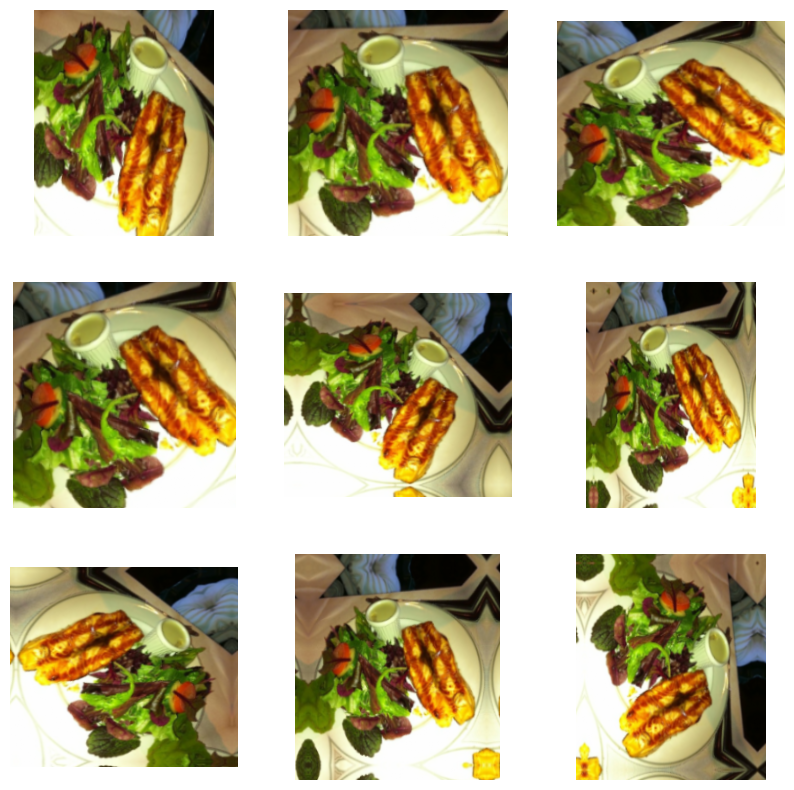

In [31]:
# 也可以一次做資料擴增好幾張
for image, _ in train_data_1_percent.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(first_image,training = True)   # 如果需要增加維度，可以寫 `tf.expand_dims(img, 0).shape`
    print(augmented_image.shape)
    plt.imshow(augmented_image / 255) 
    plt.axis('off')

## <a id='toc1_7_'></a>[**Model 1 : Feature extraction trasfer learning on 1% of the data with data augmentation**](#toc0_)

In [32]:
tf.keras.Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [33]:
# Setup input shape and base model, freezing the base model layer

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after augmentation) and don't train it
x = base_model(x, training=False)    # Very similar with `base_model.trainable = False`, jsut rewrite it down here

# Pool output feature of the base 
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dnese layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model using the inputs and output
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# Fit the model and save its history
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs = 10,
                                 steps_per_epoch = len(train_data_1_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "1_percent_data_augmentation")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20230527-222454
Epoch 1/10
3/3 [==============================] - 3s 692ms/step - loss: 2.3584 - accuracy: 0.1714 - val_loss: 2.2293 - val_accuracy: 0.1316
Epoch 2/10
3/3 [==============================] - 1s 494ms/step - loss: 2.1579 - accuracy: 0.2714 - val_loss: 2.1154 - val_accuracy: 0.2023
Epoch 3/10
3/3 [==============================] - 1s 470ms/step - loss: 1.9350 - accuracy: 0.4000 - val_loss: 2.0189 - val_accuracy: 0.2796
Epoch 4/10
3/3 [==============================] - 1s 442ms/step - loss: 1.7044 - accuracy: 0.5429 - val_loss: 1.9317 - val_accuracy: 0.3388
Epoch 5/10
3/3 [==============================] - 1s 442ms/step - loss: 1.6335 - accuracy: 0.5714 - val_loss: 1.8477 - val_accuracy: 0.3931
Epoch 6/10
3/3 [==============================] - 1s 404ms/step - loss: 1.5058 - accuracy: 0.6286 - val_loss: 1.7588 - val_accuracy: 0.4227
Epoch 7/10
3/3 [==============================] - 1s 417ms/step -

In [34]:
# Check out a model summary

model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [35]:
# Evuluate all test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 3s 34ms/step - loss: 1.5049 - accuracy: 0.5704


[1.5049220323562622, 0.5703999996185303]

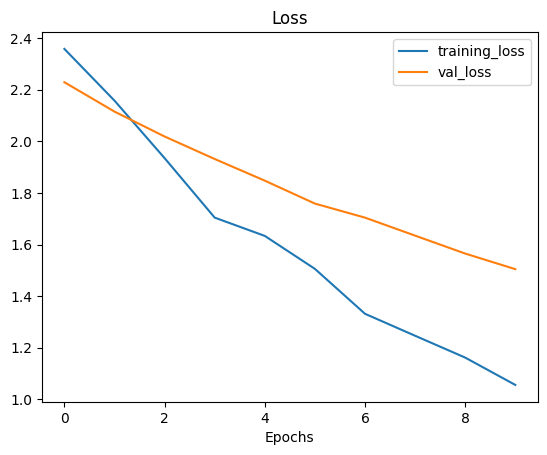

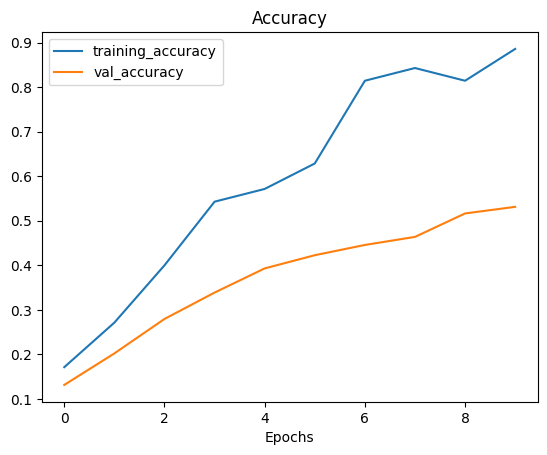

In [36]:
# How do the model with 1% of the and data augmentation loss curves look?

plot_loss_curves(history_1_percent)

## <a id='toc1_8_'></a>[**Model 2 : Feature extraction trasfer learning on 10% of the data with data augmentation**](#toc0_)

In [37]:
# get 10% of data (uncomment if you don't have it)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [38]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_10_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
# How many images are in our directory
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [40]:
# check the file structure
import os

def list_files(startpath, show_file = False):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        if show_file == True:
            for f in files:
                print('{}{}'.format(subindent, f))

list_files("10_food_classes_10_percent", show_file = False)

10_food_classes_10_percent/
    test/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/
    train/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/


In [41]:
# Create model 2 with data augmentation built in

# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.Rescaling(scale=1./255) # if you are using a model such as ResNet,  you'll need to rescale your data, efficientnet has rescaling built-in
], name= "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a fronzen base model (alse called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs, training = True)   # augment our training image (augmentation doesn't occur on test data)

# pass augmented image to base model but keep it in inference mode, this also insures BatchNormalization layers don't get updated
# https://keras.io/guides/transfer_learning/#build-a-model
x = base_model(x, training = False) 

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [42]:
# from top to bottom: input_layer -> data_augmentation -> EfficientNetB0. 
# The input_layer serves as the input to the data_augmentation layer, 
# and the output of data_augmentation is then passed to the EfficientNetB0 model.
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### <a id='toc1_8_1_'></a>[**Creating a ModelCheckpoint callback**](#toc0_)

The ModelCheckpoint callback intermediately saves our model(the full model or just the weight)

In [43]:
# set checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath = checkpoint_path,
                                                            monitor = 'val_loss',
                                                            verbose = 1,
                                                            save_best_only = False,
                                                            save_weights_only = True,
                                                            mode = 'auto',
                                                            save_freq='epoch',  
                                                            options=None,
                                                            initial_value_threshold=None,
                                                        )

### <a id='toc1_8_2_'></a>[**Fit model 2 passing the the ModelCheckpoint callback**](#toc0_)

In [44]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

# Fit the model and save its history
hirstory_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                        epochs = initial_epochs,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                        callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_data_augmentation"),
                                                   checkpoint_callback ])  # 


Saving TensorBoard log files to: transfer_learning/10_percent_data_augmentation/20230527-222511
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0154 - accuracy: 0.3320
Epoch 1: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 7s 229ms/step - loss: 2.0154 - accuracy: 0.3320 - val_loss: 1.5872 - val_accuracy: 0.5888
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3756 - accuracy: 0.6640
Epoch 2: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 4s 172ms/step - loss: 1.3756 - accuracy: 0.6640 - val_loss: 1.2065 - val_accuracy: 0.6859
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.7240
Epoch 3: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 4s 159ms/step - loss: 1.0777 - accuracy: 0.7240 - val_loss: 1.0518 - val_accuracy: 0.7204
E

In [45]:
# what were model_0 results?

model_0.evaluate(test_data)


79/79 [==============================] - 3s 33ms/step - loss: 0.6824 - accuracy: 0.7952


[0.6823753714561462, 0.795199990272522]

In [46]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 0.8446 - accuracy: 0.7624


[0.8445520401000977, 0.7623999714851379]

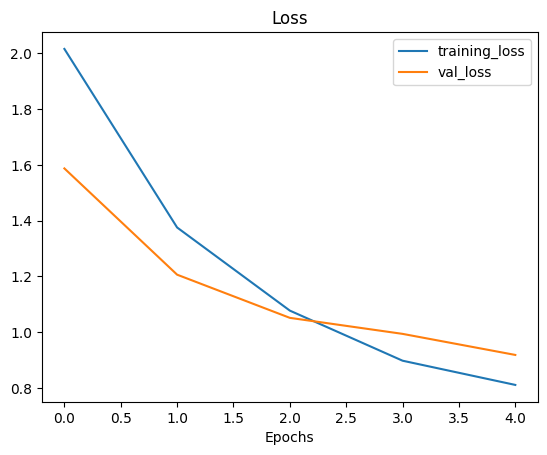

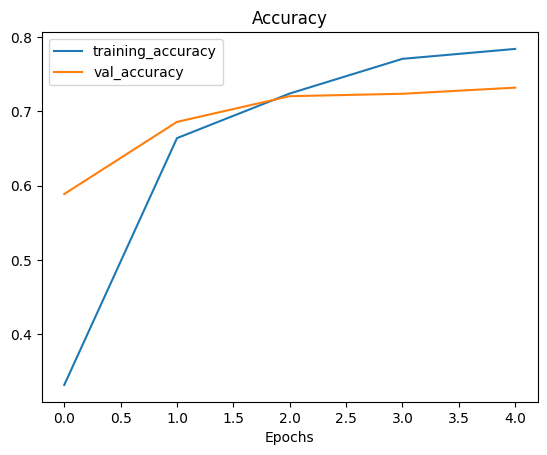

In [47]:
# Plot model loss curves
plot_loss_curves(hirstory_10_percent_data_augmentation)

### <a id='toc1_8_3_'></a>[Losding in checkpointed weights](#toc0_)

Loading in checkpointed weights returns a model to a specific checkpoint.

In [48]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [49]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

52/79 [==================>...........] - ETA: 2s - loss: 0.8621 - accuracy: 0.7590

In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check to see if loaded model results are very close to our previous non-laoded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([False, False])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[ 0.00536406 -0.00160003]


## <a id='toc1_9_'></a>[**Model 3 : Fine-tuning an existing model on % of the data**](#toc0_)

> 🔑**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

Check which layer is untrainable

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb86a89e790> True
<keras.engine.sequential.Sequential object at 0x7fb8605fcf10> True
<keras.engine.functional.Functional object at 0x7fb8506983d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb9ab4dab20> True
<keras.layers.core.dense.Dense object at 0x7fb95ffe6eb0> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers) :
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fb86af7eb50> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fb86af7eb80> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fb86afb4670> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fb9ab453e80> False
4 <keras.layers.convolutional.Conv2D object at 0x7fb86aa23190> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb860295cd0> False
6 <keras.layers.core.activation.Activation object at 0x7fb86a886a00> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fb86026f820> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb86026f610> False
9 <keras.layers.core.activation.Activation object at 0x7fb860295ca0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb8605d8400> False
11 <keras.layers.core.reshape.Reshape object at 0x7fb86027ac10> False
12 <keras.layers.convo

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Unfreeze layers for the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False 

In [ ]:
# check which layers are tunable (trainable)
for i, layer in enumerate(base_model.layers) :
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fb86af7eb50> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fb86af7eb80> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fb86afb4670> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fb9ab453e80> False
4 <keras.layers.convolutional.Conv2D object at 0x7fb86aa23190> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb860295cd0> False
6 <keras.layers.core.activation.Activation object at 0x7fb86a886a00> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fb86026f820> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb86026f610> False
9 <keras.layers.core.activation.Activation object at 0x7fb860295ca0> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb8605d8400> False
11 <keras.layers.core.reshape.Reshape object at 0x7fb86027ac10> False
12 <keras.layers.convo

In [ ]:
# How many trainable variables are in our base model?
print(len(base_model.trainable_variables))

10


In [ ]:
# Recompile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10*
                metrics=["accuracy"])

> 🔑**Note:** when using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# check which layers are tunable (trainable)
for i, layer in enumerate(model_2.layers[2].layers) :
    print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable layer
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine tune for anither 5 epochs
fine_tune_epochs = initial_epochs +5

# Refit the model
history_fine_tune_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                                                epochs = fine_tune_epochs,
                                                                steps_per_epoch = len(train_data_10_percent),
                                                                validation_data = test_data,
                                                                validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                                                initial_epoch = hirstory_10_percent_data_augmentation.epoch[-1], # start training from previous last epoch
                                                                callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_fine_tune_last_10"),
                                                                        checkpoint_callback ])  # 


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230527-220341
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7987
Epoch 5: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 7s 192ms/step - loss: 0.6853 - accuracy: 0.7987 - val_loss: 0.7138 - val_accuracy: 0.7730
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.8200
Epoch 6: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 3s 141ms/step - loss: 0.5848 - accuracy: 0.8200 - val_loss: 0.6667 - val_accuracy: 0.7714
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.8427
Epoch 7: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 3s 135ms/step - loss: 0.5178 - accuracy: 0.8427 - val_loss: 0.6645 - val_accuracy: 0.782

In [ ]:
# evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epoch)
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 5s 64ms/step - loss: 0.6211 - accuracy: 0.7940


[0.6210944652557373, 0.7940000295639038]

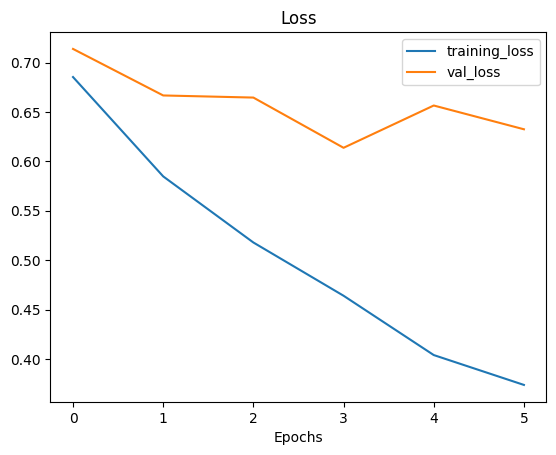

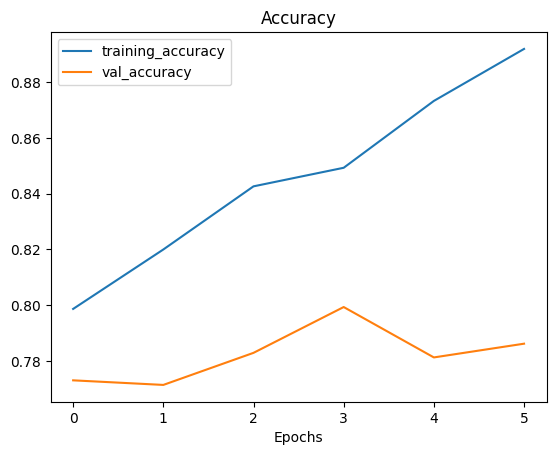

In [ ]:
# Check out the loss curves
plot_loss_curves(history_fine_tune_10_percent_data_augmentation)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create the function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plots for loss
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

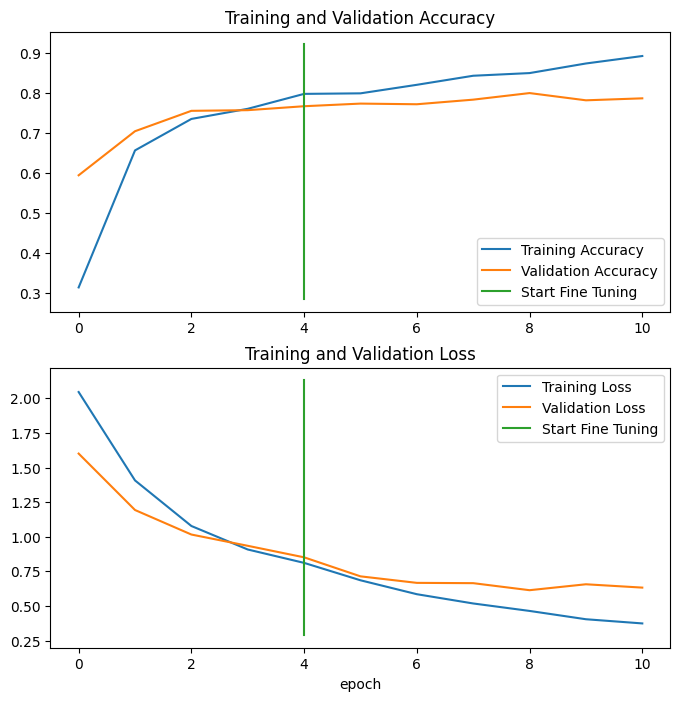

In [ ]:
compare_history(hirstory_10_percent_data_augmentation,history_fine_tune_10_percent_data_augmentation)

## **Model 4: Fine-tuning and existing model on all of the data**

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
download_file("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip", unzip_data=True, delete_zip_data=True)

FileNotFoundError: [Errno 2] No such file or directory: '10_food_classes_all_data.zip'